In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import time
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima

In [4]:
dfs1 = pd.read_csv('Data/Solar Data/Solar 1.csv')

In [5]:
dfs1

,Unnamed: 0,series_value,datetime,Year,Month,Day_of_Month,Hour,minutes,series_name
0,0,0.00,2018-12-31 13:00:00,2018,12,31,13,0,Solar1
1,4,0.00,2018-12-31 14:00:00,2018,12,31,14,0,Solar1
2,8,0.00,2018-12-31 15:00:00,2018,12,31,15,0,Solar1
3,12,0.00,2018-12-31 16:00:00,2018,12,31,16,0,Solar1
4,16,0.00,2018-12-31 17:00:00,2018,12,31,17,0,Solar1
...,...,...,...,...,...,...,...,...,...
16086,64344,0.01,2020-10-31 19:00:00,2020,10,31,19,0,Solar1
16087,64348,0.42,2020-10-31 20:00:00,2020,10,31,20,0,Solar1
16088,64352,1.27,2020-10-31 21:00:00,2020,10,31,21,0,Solar1
16089,64356,2.35,2020-10-31 22:00:00,2020,10,31,22,0,Solar1


In [8]:
data = dfs1['series_value'][8000:10000]

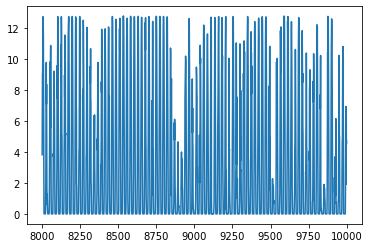

In [9]:
plt.plot(data)

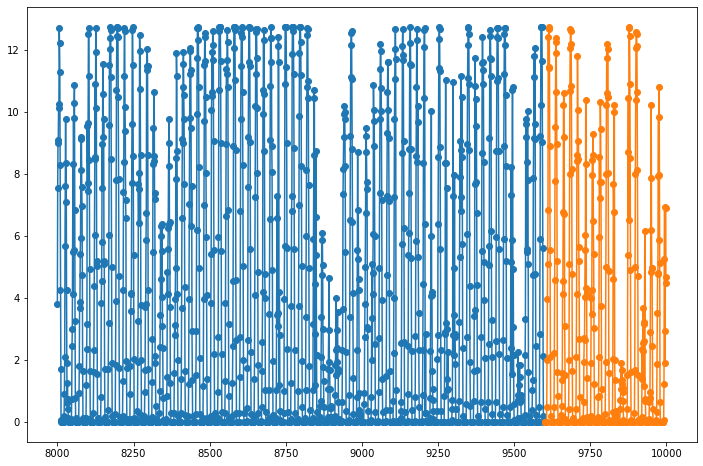

In [10]:
train_size = 0.8

ts = data

split_idx = round(len(data)* train_size)

# Split
train = ts.iloc[:split_idx]
test = ts.iloc[split_idx:]

# Visualize split
fig,ax= plt.subplots(figsize=(12,8))
kws = dict(marker='o')
plt.plot(train, label='Train', **kws)
plt.plot(test, label='Test', **kws)

In [11]:
modelactual = auto_arima(train, start_p=0, start_q=0, seasonal=True)
modelactual.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1600
Model:               SARIMAX(5, 0, 1)   Log Likelihood               -2829.424
Date:                Wed, 28 Sep 2022   AIC                           5674.849
Time:                        18:13:02   BIC                           5717.871
Sample:                             0   HQIC                          5690.824
                               - 1600                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2316      0.041      5.616      0.000       0.151       0.312
ar.L1          1.9016      0.049     38.748      0.000       1.805       1.998
ar.L2         -0.9401      0.060    -15.798      0.000      -1.057      -0.823
ar.L3         -0.1697      0.033     -5.130      0.000      -0.235      -0.105
ar.L4          0.2102      0.032      6.559      0.000       0.147       0.273
ar.L5         -0.0684      0.020     -3.478      0.001      -0.107      -0.030
ma.L1         -0.8036      0.049    -16.520      0.000      -0.899      -0.708
sigma2         2.0076      0.047     42.950      0.000       1.916       2.099
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              3249.54
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.53   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [13]:
data = train
# define model
my_order = (5, 1, 1)
my_seasonal_order = (5, 1, 1, 24)
model = SARIMAX(data, order=my_order, seasonal_order=my_seasonal_order)
# fit model
model_fit = model.fit()
# one step forecast
yhat = model_fit.predict(end=len(test))

In [14]:
yhat

8000    0.000000
8001    3.809999
8002    7.529999
8003    8.989999
8004    9.099998
          ...   
8396    0.311099
8397   -0.074754
8398   -0.258024
8399   -0.107839
8400   -0.141579
Name: predicted_mean, Length: 401, dtype: float64

In [35]:
lst = []
for i in range(8001, 8394):
    lst.append(yhat[i])

In [36]:
forecastdf = pd.DataFrame(lst, columns=['forecast']) 

In [17]:
test

9600    0.00
9601    0.00
9602    0.00
9603    0.00
9604    0.00
        ... 
9995    1.90
9996    2.94
9997    6.91
9998    4.49
9999    4.68
Name: series_value, Length: 400, dtype: float64

In [32]:
lst = []
for i in range(9607, 10000):
    lst.append(test[i])

In [33]:
testdfnew = pd.DataFrame(lst, columns=['test']) 

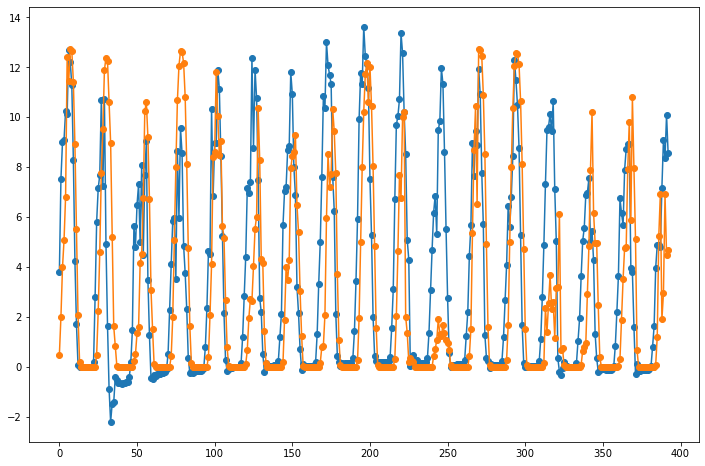

In [37]:
fig,ax= plt.subplots(figsize=(12,8))
kws = dict(marker='o')
plt.plot(forecastdf['forecast'], label='Forecast', **kws)
plt.plot(testdfnew['test'], label='Test', **kws)

In [38]:
from sklearn.metrics import mean_absolute_error
import numpy as np

def mean_absolute_scaled_error(y_true, y_pred, y_train):
    e_t = y_true - y_pred
    scale = mean_absolute_error(y_train[1:], y_train[:-1])
    return np.mean(np.abs(e_t / scale))


pred = forecastdf['forecast'] 
tst = testdfnew['test']
trn = train

mean_absolute_scaled_error(pred,tst,trn)

2.186673276549256